In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Use Gromacs to generate parameter files

First we check the version of Gromacs available in our path

In [2]:
from adaptivemastermsm.system import system

In [3]:
system.check_gmx()

b'/usr/local/gromacs/2018.8/bin/gmx\n'


Next we generate the alaTB system, which requires a `gro` or `pdb` file, a force field for generating the topology and a water model.

In [4]:
alaTB = system.System('data/alaTB.gro', forcefield='amber03', water='tip3p')

In [5]:
alaTB.ff

'amber03'

In [6]:
alaTB.wat

'tip3p'

In [7]:
alaTB.pdb

'data/alaTB.gro'

To produce parameters for the force field selected we use the `gen_top()` method in the `System` class.

In [32]:
alaTB.gen_top()

gmx pdb2gmx -f data/alaTB.gro -o conf.gro -p topol.top -ff amber03 -water tip3p


In [9]:
alaTB.gro, alaTB.top

('conf.gro', 'topol.top')

### Setting up the simulation box
Next we start building the simulation box for the system, which we do using additional methods in `System`. First we create the simulation box and then we solvate the protein with water.

In [33]:
alaTB.build_box()

gmx editconf -f conf.gro -o conf_edit.gro -c -d 1.000000 -bt cubic


As the simulation setup progresses the attributes of the alaTB class gradually update.

In [34]:
alaTB.gro

'conf_edit.gro'

In [35]:
alaTB.solvate()

gmx solvate -cp conf_edit.gro -cs spc216.gro -p topol.top -o conf_solv.gro


In [36]:
alaTB.gro

'conf_solv.gro'

We can additionally add ions. For this we can define a target concentration or simply neutralize the simulation box. In this case we simply leave the default options (neutralize), which does not add any ions.

In [37]:
alaTB.ionize()

gmx grompp -f data/minimization.mdp -c conf_solv.gro -p topol.top -o ions.tpr
gmx genion -s ions.tpr -o conf_solv_ions.gro -p topol.top -neutral


In [38]:
alaTB.gro

'conf_solv_ions.gro'

### Equilibration
Now that we have our simulation box ready, we can start running the equilibration of the system. The first step is an energy minimization. For this we invoke the `Launcher` class for this specific type of run.

In [16]:
from adaptivemastermsm.launcher import launcher

In this case we are running a minimization; for this we need the `minimization.mdp` file. Helper functions can write `mdp` files for different types of simulation. We first set up the simulation using the `gen_tpr()` method, and finally we run the simulation using `gmx_run()`.

In [17]:
minim = launcher.Launcher(alaTB)
minim.gen_tpr(mdp='data/mdp/minim.mdp', tpr='data/minim.tpr')

gmx grompp -c conf_solv_ions.gro -p topol.top -f data/mdp/minim.mdp -o data/minim.tpr -r conf_solv_ions.gro


In [18]:
minim.gmx_run(out="data/minim")

gmx mdrun -v -s data/minim.tpr -deffnm data/minim


Each object of the `Launcher` class is aware of its output, so you can examine what went on in the simulation.

In [19]:
print(minim.error.decode(encoding='utf-8'))

                      :-) GROMACS - gmx mdrun, 2018.8 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [20]:
minim.out

'data/minim'

We can also access the GMX tools to calculate stuff, like in the case of the potential energy which we are minimizing in this calculation.

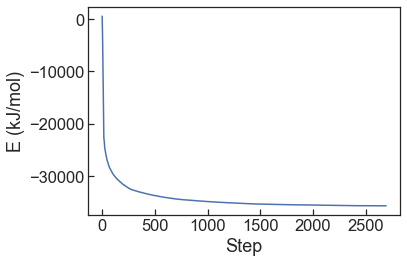

In [21]:
os.system("gmx energy -f %s.edr -o energy_mini.xvg <<EOF\n9\nEOF"%minim.out)

emin = np.loadtxt("energy_mini.xvg", comments=["#", "@"])
fig, ax = plt.subplots()
ax.plot(emin[:,0], emin[:,1])
ax.set_xlabel('Step')
ax.set_ylabel('E (kJ/mol)')
plt.tight_layout()

After the minimization we run two other simulations, one in the NVT ensemble at the temperature of interest with position restraints on the protein, allowing for the solvent to equilibrate.

In [22]:
alaTB_min = copy.deepcopy(minim.system)

In [23]:
posre = launcher.Launcher(alaTB_min)
posre.gen_tpr(mdp='data/mdp/nvt_posre.mdp', tpr='data/posre.tpr')

gmx grompp -c data/minim.gro -p topol.top -f data/mdp/nvt_posre.mdp -o data/posre.tpr -r data/minim.gro


In [24]:
posre.gmx_run(out="data/posre")

gmx mdrun -v -s data/posre.tpr -deffnm data/posre


In [25]:
posre.system.gro

'data/posre.gro'

In [26]:
print(posre.error.decode(encoding='utf-8'))

                      :-) GROMACS - gmx mdrun, 2018.8 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [27]:
posre.system.gro

'data/posre.gro'

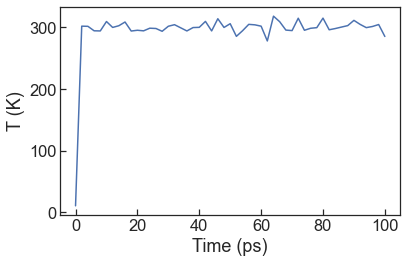

In [28]:
os.system("gmx energy -f %s.edr -o posre_temp.xvg <<EOF\n15\nEOF"%posre.out)

temp = np.loadtxt("posre_temp.xvg", comments=["#", "@"])
fig, ax = plt.subplots()
ax.plot(temp[:,0], temp[:,1])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('T (K)')
plt.tight_layout()

The final step in the equilibration is a simulation in the NPT ensemble to converge the box volume. We repeat the same process of generating an instance of `Launcher` that uses as first step the `gro` file from the last simulation.

In [29]:
alaTB_posre = copy.deepcopy(posre.system)
npt = launcher.Launcher(alaTB_posre)

In [49]:
npt.gen_tpr(mdp='data/mdp/npt.mdp', tpr='data/npt.tpr')

gmx grompp -c data/npt.gro -p topol.top -f data/mdp/npt.mdp -o data/npt.tpr -r data/npt.gro


In [51]:
npt.gmx_run(out="data/npt")

gmx mdrun -v -s data/npt.tpr -deffnm data/npt


After the simulation we can check whether the simulation has been sufficiently long to converge the density of the box. Again we use the GMX tools to do this.

In [52]:
os.system("gmx energy -f %s.edr -o npt_rho.xvg <<EOF\n21\nEOF"%npt.out)

0

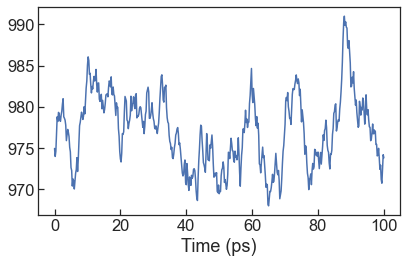

In [53]:
rho = np.loadtxt("npt_rho.xvg", comments=["#", "@"])
fig, ax = plt.subplots()
ax.plot(rho[:,0], rho[:,1])
ax.set_xlabel('Time (ps)')
#ax.set_ylabel('$\rho$ (kg/m^3)')
plt.tight_layout()

In [54]:
alaTB_npt = copy.deepcopy(npt.system)
nvt = launcher.Launcher(alaTB_npt)

In [56]:
nvt.gen_tpr(mdp='data/mdp/sd_nvt.mdp', tpr='data/nvt.tpr')

gmx grompp -c data/npt.gro -p topol.top -f data/mdp/sd_nvt.mdp -o data/nvt.tpr -r data/npt.gro


In [ ]:
nvt.gmx_run(out="data/nvt")